In [72]:
%matplotlib widget
import CoolProp 
from CoolProp.CoolProp import PropsSI
import pandas as pd
import numpy as np
import glob,sys,socket,fileinput
import os.path
import matplotlib.pyplot as plt
import socket

In [73]:
nombre_compu = socket.gethostname()

In [74]:
D = 50/1000 #Diametro de la parte cilindrica [m]
rho = PropsSI('D', 'T', 288.15, 'P', 1e5, 'AIR') #Densidad del aire [kg/m3]
mu = PropsSI('V', 'T', 288.15, 'P', 1e5, 'AIR') #Viscocidad del aire [Pa. s]
L = 0.175*2 #Largo del cilindro en metros
A = D*L ## area proyectada

In [75]:
rho,mu,mu/rho

(1.2095062699200583, 1.796134391659531e-05, 1.4850145355412218e-05)

In [76]:
# en calibrationData va el nombre del archivo que 
CDfile = "CD.txt"
CDData=open(CDfile,"w")
#CDData.write('txt,Media Lift,Media Drag,STD Lift,STD Drag\n');
CDData.write('txt,MediaLift,MediaDrag\n');

In [77]:
VelocityFile = "Velocidades Calibradas/Velocidades.txt"
VelocityData = pd.read_csv(VelocityFile)
PolinomioVelocidad=np.polyfit(VelocityData["V [V]"],VelocityData["U [m/s]"],1)

In [78]:
RawDataFolder = "Raw Data/"
files = np.sort(glob.glob(RawDataFolder+'*.txt'))
VoltajeMedicion=[]
VelocidadMedicion=[]
ReMedicion=[]
for i in files:
    item = i.strip("Raw Data\\V")
    if nombre_compu == 'juan-i7':
        item  = i.strip("Raw Data/V")
    item = item.strip(".txt")
    item = item.strip("")
    VoltajeMedicion.append(float(item))
    Vitem = PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
    VelocidadMedicion.append(Vitem)
    ReMedicion.append(Vitem*D*rho/mu)

In [79]:
Inicial= {
    "Voltaje" : VoltajeMedicion,
    "Velocidad" : VelocidadMedicion,
    "Re" : ReMedicion,
    }
DFInicial = pd.DataFrame(Inicial)

In [80]:
VelocidadMedicion

[-0.12004662522202465,
 0.9020802952930727,
 1.8253802619893427,
 2.3158547735346353,
 2.7367843916518644,
 3.2107877442273525,
 3.6591692939609226,
 4.67489076376554,
 4.857903641207814]

In [81]:
for i in files[1:2]:
    datos = pd.read_csv(i, sep=",", header=None,skiprows=3)
    datos = datos[:-100]
    datos.columns = ["Lift", "Drag", "Time"]
    datos = datos.astype(float)
    datos=datos[500:5500]
    mediaLift=datos["Lift"].mean()
    stdLift=datos["Lift"].std()
    mediaDrag=(datos["Drag"].mean())
    stdDrag=(datos["Drag"].std())
    # Las lineas vienen como #.txt,mediaL,mediaD,stdL,stdD
    #CDData.write(i+","+str(mediaLift)+","+str(mediaDrag)+","+str(stdLift)+","+str(stdDrag)+"\n")
    CDData.write(i+","+str(mediaLift)+","+str(mediaDrag)+"\n")
CDData.close()

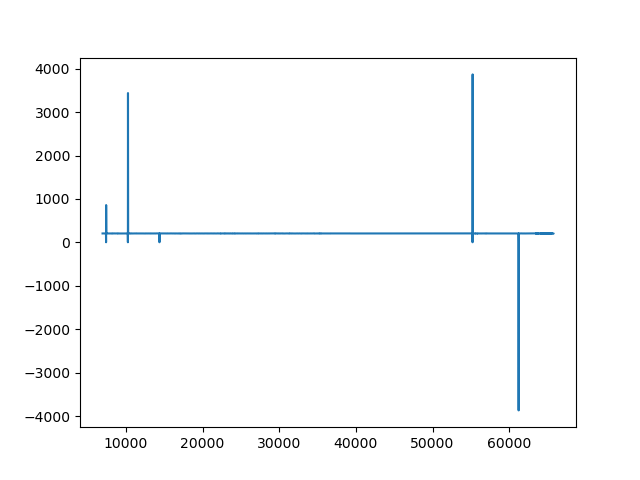

In [83]:

fig,ax = plt.subplots()
ax.plot(datos['Time'],datos['Lift'])

In [40]:
CDData.close()
DFFinal = pd.read_csv(CDfile)

In [41]:
## Tomo la referencia y la borro del original

DatosCD=pd.concat([DFFinal,DFInicial],axis =1)
Referencia=DatosCD[:1]
Drag0=Referencia["MediaDrag"][0]
Lift0=Referencia["MediaLift"][0]
DatosCD=DatosCD.drop([0]) 

In [22]:
### Uso la referencia para poner en 0 todo
DatosCD["Drag"]= DatosCD["MediaDrag"]-Drag0
DatosCD["Lift"]= DatosCD["MediaLift"]-Lift0

In [23]:
#limpio los datos que ya no me sirven

DatosCD=DatosCD.drop("txt", axis=1)
DatosCD=DatosCD.drop("MediaDrag", axis=1)
DatosCD=DatosCD.drop("MediaLift", axis=1)

In [24]:
DatosCD["CD"]=DatosCD["Drag"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]**2)
DatosCD["CL"]=DatosCD["Lift"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]**2)

In [25]:
DatosCD

,Voltaje,Velocidad,Re,Drag,Lift,CD,CL
1,11.17,0.902080,3037.277662,2.437404,3.784336,2.775503,4.309271
2,21.26,1.825380,6146.001330,12.076346,4.995288,3.358407,1.389179
3,26.62,2.315855,7797.414497,19.166822,5.422122,3.311555,0.936809
4,31.22,2.736784,9214.672066,26.924056,7.172060,3.330917,0.887293
5,36.40,3.210788,10810.627328,37.668442,9.057546,3.385782,0.814126
6,41.30,3.659169,12320.314739,49.069454,9.515616,3.395867,0.658531
7,52.40,4.674891,15740.218873,81.856516,16.053008,3.470682,0.680641
8,54.40,4.857904,16356.417816,87.301936,15.343144,3.427919,0.602450


<AxesSubplot:xlabel='Re'>

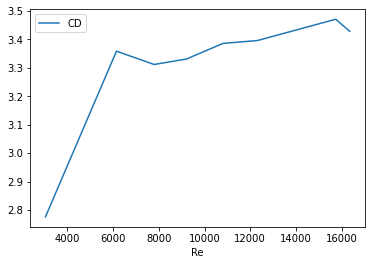

In [26]:
DatosCD.plot(x="Re", y="CD")